<a href="https://colab.research.google.com/github/alexandrgsv/dynamic_models/blob/main/Tracked_Vehicle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

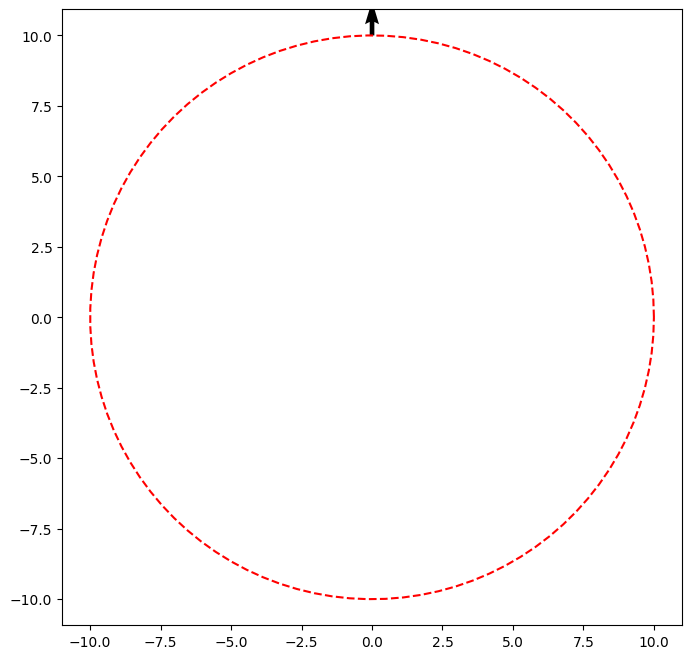

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
L = 2.5  # Wheelbase length
Kp = 3.0  # Proportional gain
Ki = 1  # Integral gain
Kd = 1  # Derivative gain
dt = 0.01  # Time step

# Circle trajectory parameters
r = 10.0  # Radius
xc = 0.0  # X-coordinate of center
yc = 0.0  # Y-coordinate of center
v = 5.0  # Velocity

# Vehicle parameters
m = 1000.0  # Mass
Iz = 2000.0  # Moment of inertia around z-axis
Cf = 100000.0  # Front tire cornering stiffness
Cr = 100000.0  # Rear tire cornering stiffness
a = 1.5  # Distance from CG to front axle
b = 1.5  # Distance from CG to rear axle
mu = 0.8  # Coefficient of friction

# Initial conditions
x = 0.0
y = r
theta = np.pi / 2
theta_dot = 0.0
integral_error = 0.0
slip_ratio_f = 0.0
slip_ratio_r = 0.0

# Lists to store data for plotting
x_list = [x]
y_list = [y]
theta_list = [theta]

# Loop for lateral control and trajectory generation
while np.sqrt((x - xc) ** 2 + (y - yc) ** 2) < r:
    # Calculate cross-track error (distance between vehicle and center of circle)
    cte = np.sqrt((x - xc) ** 2 + (y - yc) ** 2) - r

    # Calculate heading error (difference between vehicle heading and tangent to circle)
    heading_error = np.arctan2(y - yc, x - xc) - np.arctan2(v, cte)

    # Calculate steering angle using Stanley controller
    derivative_error = heading_error - theta_list[-1]
    integral_error += heading_error * dt
    steering_angle = np.arctan2(Kp * heading_error + Ki * integral_error + Kd * derivative_error, v)

    # Calculate slip angles
    alpha_f = np.arctan2(v * np.sin(steering_angle) + a * theta_dot, v * np.cos(steering_angle)) - steering_angle
    alpha_r = np.arctan2(b * theta_dot - v * np.sin(steering_angle), v * np.cos(steering_angle))

    # Calculate slip ratios
    if v != 0.0:
        slip_ratio_f = (v - a * theta_dot) / (v + 0.0001)
        slip_ratio_r = (v - b * theta_dot) / (v + 0.0001)

    # Calculate lateral forces
    Fyf = -Cf * alpha_f
    Fyr = -Cr * alpha_r

    # Calculate longitudinal force
    if abs(slip_ratio_f) < 1.0:
        Fxf = Cf * slip_ratio_f
    else:
        Fxf = mu * m * 9.81 / 2.0

    if abs(slip_ratio_r) < 1.0:
        Fxr = Cr * slip_ratio_r
    else:
        Fxr = mu * m * 9.81 / 2.0

    # Calculate vehicle dynamics
    theta_ddot = (a * Fyf * np.cos(steering_angle) + a * Fxf * np.sin(steering_angle) - b * Fyr) / Iz
    theta_dot += theta_ddot * dt
    theta += theta_dot * dt

    x_dot = v * np.cos(theta)
    y_dot = v * np.sin(theta)
    v_dot = (Fxf + Fxr - Fyf * np.sin(steering_angle)) / m
    v += v_dot * dt

    x += x_dot * dt
    y += y_dot * dt

    # Append data to lists for plotting
    x_list.append(x)
    y_list.append(y)
    theta_list.append(theta)

# Plot trajectory and heading
plt.figure(figsize=(8, 8))
plt.plot(x_list, y_list, 'b-', linewidth=2)
plt.quiver(x_list, y_list, np.cos(theta_list), np.sin(theta_list))
plt.plot(xc + r * np.cos(np.linspace(0, 2 * np.pi, 100)), yc + r * np.sin(np.linspace(0, 2 * np.pi, 100)), 'r--')
plt.axis('equal')
plt.show()